## Задача

Есть мнение, что “раньше снимали настоящее кино, не то что сейчас”. 

Задача состоит в том, чтобы проверить это утверждение, используя файлы с рейтингами фильмов (файл ratings.csv и movies.csv из базы https://grouplens.org/datasets/movielens). Их можно найти в материалах домашнего задания "Продвинутый pandas". 

Всего в базе 100 004 оценки для 9125 фильмов с 1902 по 2016 годы. Эти оценки были выставлены 671 пользователем. О пользователях неизвестно ничего, кроме ID и времени первого и последнего посещения (никаких демографических данных нет).

Набор данных принадлежит GroupLens — исследовательской лаборатории Университета Минессоты. В его основе данные некоммерческого сайта MovieLens (http://movielens.org), который работает как рекомендательная система. На сайте зарегистрированы сотни тысяч пользователей. Ресурс существует с 1997 года.

### Что будем изучать?
* средний рейтинг по всем годам и периодам (1 период — 25 лет)
* количество оценок в разное время
* самые популярные фильмы с самым высоким рейтингом (их можно считать "настоящим кино")

## Подготовим набор данных к работе

In [449]:
# Для каждого фильма определим год и период выпуска
# Периоды позволят оценить данные агрегированно

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import re

data_rating = pd.read_csv('ratings.csv')
data_movies = pd.read_csv('movies.csv')

title = data_movies['title']
years = [str(x) for x in range(1902, 2016)]

def production_year(title):
    year = ''.join(re.findall(r'\d{4}', title))
    if year in years:
        return int(year)
data_movies['year'] = title.apply(production_year)

data_merge = data_rating.merge(data_movies, on='movieId', how='left')
data_merge['year'] = data_merge.year.astype('Int64')
data_merge.dropna(inplace=True)

def classify_by(year):
    if year <= 1927:
        year_class = '1902-1927'
    elif year <= 1942:
        year_class = '1927-1952'
    elif year <= 1977:
        year_class = '1952-1977'
    elif year <= 1992:
        year_class = '1977-1992'
    elif year < 2017:
        year_class = '1992-2017'
    return year_class
    
data_merge['year_class'] = data_merge['year'].apply(classify_by)
data_merge.head()

,userId,movieId,rating,timestamp,title,genres,year,year_class
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,1995,1992-2017
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical,1941,1927-1952
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller,1996,1992-2017
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,1981,1977-1992
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,1989,1977-1992


## Определим средние значения и количество оценок по годам и периодам

Text(0, 0.5, 'Средний рейтинг')

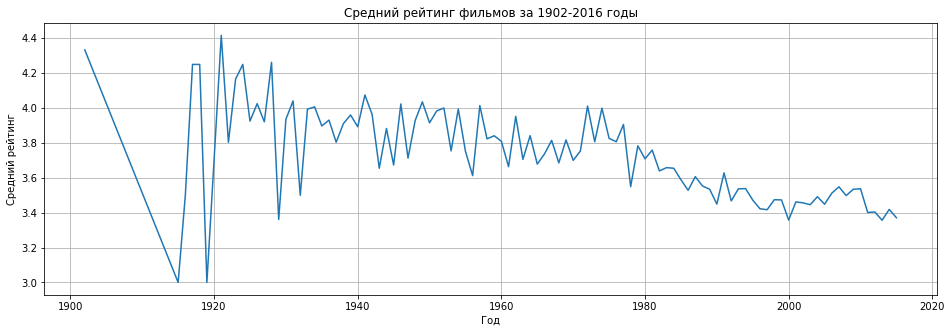

In [2]:
# Построим общий график среднего рейтинга за все годы
by_year = data_merge.groupby('year_class').agg(['mean'])['rating']

rcParams['figure.figsize'] = 16,5
plt.plot(by_year)
plt.title('Средний рейтинг фильмов за 1902-2016 годы')
plt.grid()
plt.xlabel('Год')
plt.ylabel('Средний рейтинг')

Средний рейтинг фильмов за 1902-2016 годы показывает общую тенденцию к уменьшению среднего рейтинга, за исключением периода до 1920 года, в котором недостаточно значений для выявления полной закономерности. 

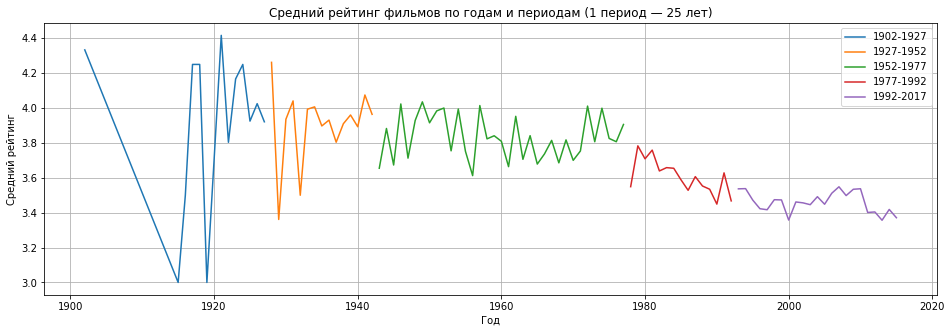

In [6]:
# Оценим поведение величины в разных периодах
by_year_all = data_merge.groupby(['year_class', 'year']).agg(['mean'])['rating']
periods = ['1902-1927', '1927-1952', '1952-1977', '1977-1992', '1992-2017']
for period in periods:
    plt.plot(by_year_all.loc[period])
    plt.title('Средний рейтинг фильмов по годам и периодам (1 период — 25 лет)')
    plt.xlabel('Год')
    plt.ylabel('Средний рейтинг') 
    plt.grid()
    plt.legend(by_year_class.T)

Из графика видно, что чем ближе к современности, тем меньше колебание среднего значения. Самые большие колебания находятся в первых двух периодах. При этом именно фильмы, выпущенные в это время (с 1902 по 1942 годы), имеют самый высокий средний рейтинг (выше 4). В последних двух периодах, особенно где-то с 1990-х годов, средние значения остаются в небольшом диапазоне (3.4-3.6). Отсюда напрашивается мысль, что "самое" настоящее кино снимали в первой четверти ХХ века, а в последние десятилетия на суд зрителя отдают средненькие фильмы. Но не будем спешить с таким выводом, не взглянув на другие данные.  

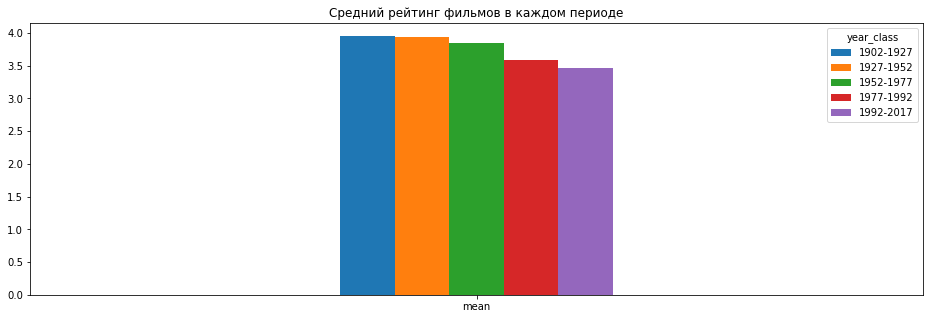

In [187]:
# Сравним обобщенный средний рейтинг фильмов в каждом периоде 
by_year_class = data_merge.groupby('year_class').agg(['mean'])['rating']
by_year_class.T.plot(kind='bar', width = 0.22, title='Средний рейтинг фильмов в каждом периоде', rot=0)

Средний рейтинг фильмов в каждом периоде сглаживает колебания, которые мы видели на предыдушем графике, представляя еще более усредненную картину. Он говорит о том же, о чем первые два графика: о понижении среднего рейтинга фильмов, но несущественном — примерно с 3.9 до 3.5. Такой взгляд на данные приводит к заключению о том, что на протяжении всей истории киношники выпускали фильмы среднего калибра (с точки зрения пользователей). Но нужно помнить, что среднее средних в каждом столбце вырисовывает ситуацию очень грубыми мазками и не может служить основой для финального вывода.      

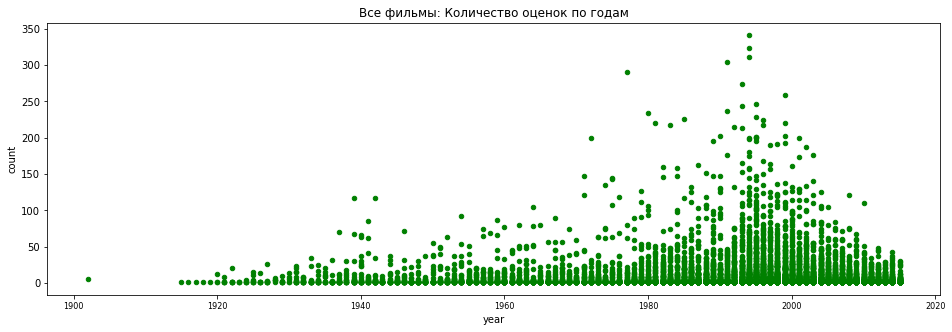

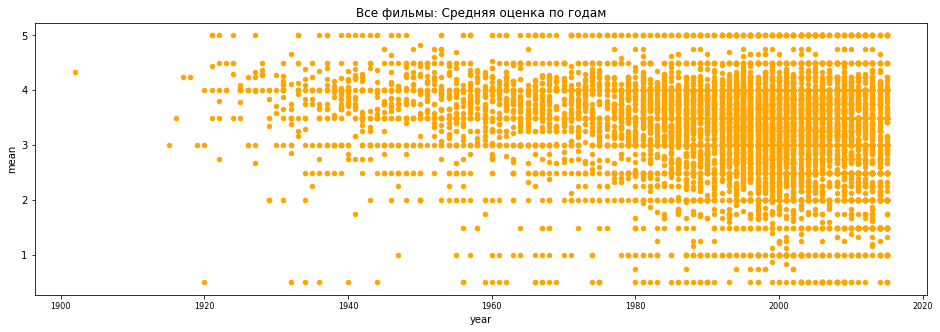

,title,mean,count,year
0,Forrest Gump (1994),4.054252,341,1994
1,Pulp Fiction (1994),4.256173,324,1994
2,"Shawshank Redemption, The (1994)",4.487138,311,1994
3,"Silence of the Lambs, The (1991)",4.138158,304,1991
4,Star Wars: Episode IV - A New Hope (1977),4.221649,291,1977
...,...,...,...,...
8965,Gone in 60 Seconds (1974),3.500000,1,1974
8966,Robot Overlords (2014),1.500000,1,2014
8967,Gone (2012),1.500000,1,2012
8968,Rock 'N' Roll High School (1979),3.000000,1,1979


In [456]:
# Посмотрим на картину детальнее, оценив количество оценок и их средних значений для всех фильмов 
all_movies = data_merge.groupby('title').agg(['mean', 'count'])['rating'].sort_values('count', ascending=False).reset_index()

def production_year(title):
    year = ''.join(re.findall(r'\d{4}', title))
    if year in years:
        return int(year)
all_movies['year'] = all_movies['title'].apply(production_year)

all_movies.plot(kind='scatter', 
        x='year', 
        y='count', 
        title='Все фильмы: Количество оценок по годам',
        color='green')
plt.show()
all_movies.plot(kind='scatter', 
        x='year', 
        y='mean', 
        title='Все фильмы: Средняя оценка по годам',
        color='orange')
plt.show()
all_movies

На этих двух визуализациях отображены количество оценок и средняя оценка для каждого фильма, выпущенного с 1902 по 2016 годы. 

Как видно, самыми популярными, то есть получившими больше всего оценок, являются фильмы, вышедшие с начала 1970-х до конца 1990-х годов — у них больше чем по 200 оценок. Это самая зрелищная (просматриваемая) группа фильмов. До 1920-х годов у фильмов почти нет оценок, отсюда обманчивое среднее значение на первых графиках: достаточно, если фильму 1902 года поставил оценку хотя бы 1 пользователь, чтобы линия средних значений воспарила под верхней границей. О более или менее адекватной средней оценке можно говорить для фильмов начиная с 1930-х годов, которые оценивали не единицы, а несколько десятков человек. Интересно, что для фильмов 2010-х годов пользователи ставили меньше оценок. Последний пик зрелищности приходится на 2000 год. 

Трудно с уверенностью сказать, почему пользователи стали меньше оценивать фильмы. Это может быть связано не только с качеством новых фильмов, но и с банальным падением интереса к сайту MovieLens (возможно, на фоне появления конкурентов, когда пользователи просто мигрировали в другой сервис, или естественным изменением образа жизни пользователя, когда на первый план вышли другие заботы).  

Что касается среднего рейтинга, то хорошо видно, что со временем основной коридор средних значений существенно изменился. Если в период с 1920-х по 1950-х годы он держался высоко и узко (от 3.5 до 4.5), то уже к 1970-м годам он расширился на пол балла до 3, а в 1980-х и 1990-х годах (самых зрелищных) его нижняя граница упала до 1.5. 

Таким образом, в периоде 1980-1990-е годы находится больше всего фильмов как с очень низким рейтингом, так и очень высоким. При этом на протяжении всего времени относительно стабильно присутствуют картины с высоким рейтингом (от 4.5). Но из-за того, что у более современных фильмов больше оценок, при анализе обощенных средних значений, как на первых графиках, может показаться, что только раннее кино было достойным высокой похвалы.

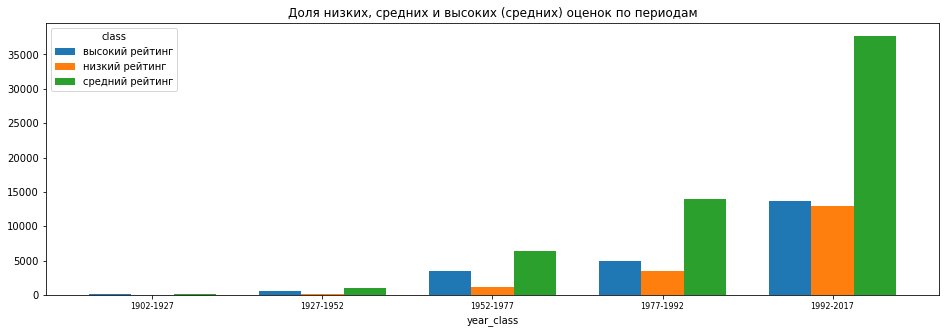

In [445]:
# Посмотрим, какие оценки (низские, средние, высокие) пользователи охотнее ставят
rating = data_rating['rating']

def classify_by(rating):
    if rating < 3.0:
        rating_class = 'низкий рейтинг'
    elif rating <= 4.0:
        rating_class = 'средний рейтинг'
    else:
        rating_class = 'высокий рейтинг'
    return rating_class
    
data_merge['class'] = rating.apply(classify_by)
by_rating = data_merge.groupby(['year_class', 'class']).agg(['count'])['rating'].unstack()

by_rating['count'].plot(kind='bar',
                        title = 'Доля низких, средних и высоких (средних) оценок по периодам',
                        width = 0.75,
                        rot=0)

Доля низких, средних и высоких (средних) оценок по периодам показывает, что структурно оценки распределялись похожим образом на протяжении всего времени. Чаще всего пользователи ставили средние оценки (от 3 до 4), примерно вполовину меньше высокие (от 4.5 до 5) и в разном соотношении низкие (до 2.5). При этом за последние 20 лет количество высоких оценок примерно было равно количеству низких, хотя в других периодах низких было меньше высоких. Это подтверждает вывод предыдущей части о том, что в более современном периоде увеличилась доля низких оценок. 

## Настоящее кино: топ-50 и частные случаи

In [500]:
# Выберем фильмы, у которых больше 100 оценок и средний рейтинг >= 4.0
pop_movies = data_merge.groupby('title').agg(['mean', 'count'])['rating'].sort_values('mean', ascending=False)
pop_movies = pop_movies.loc[(pop_movies['count'] >= 100) & (pop_movies['mean'] >= 4.0)].reset_index()

def production_year(title):
    year = ''.join(re.findall(r'\d{4}', title))
    if year in years:
        return int(year)
pop_movies['year'] = pop_movies['title'].apply(production_year)
pop_movies['year'] = pop_movies.year.astype('Int64')

# Таких фильмов 50 штук 
pop_movies.head()

,title,mean,count,year
0,"Godfather, The (1972)",4.487500,200,1972
1,"Shawshank Redemption, The (1994)",4.487138,311,1994
2,"Godfather: Part II, The (1974)",4.385185,135,1974
3,"Usual Suspects, The (1995)",4.370647,201,1995
4,Schindler's List (1993),4.303279,244,1993


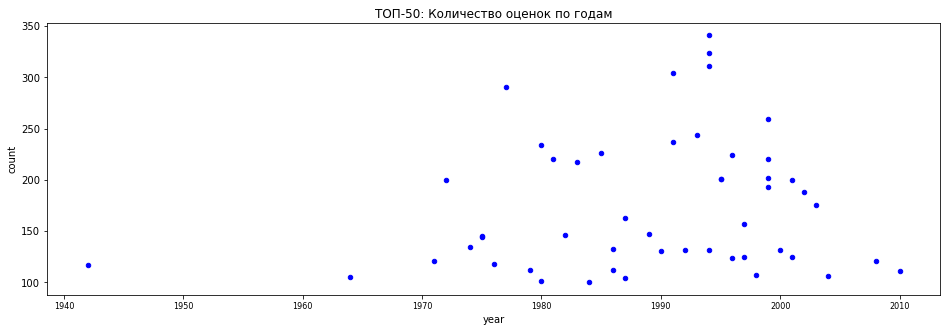

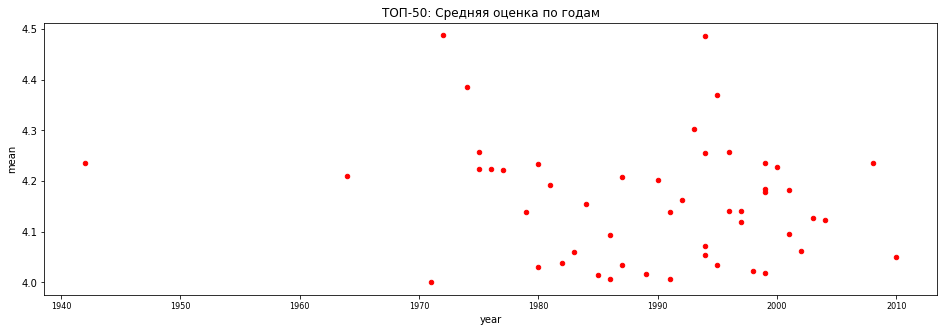

In [468]:
# Посмотрим, когда было снято больше таких фильмов
pop_movies.plot(kind='scatter', 
        x='year', 
        y='count', 
        title='ТОП-50: Количество оценок по годам',
        color='blue')
plt.show()
pop_movies.plot(kind='scatter', 
        x='year', 
        y='mean', 
        title='ТОП-50: Средняя оценка по годам',
        color='red')

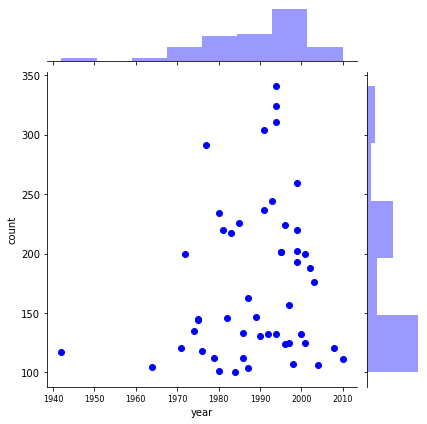

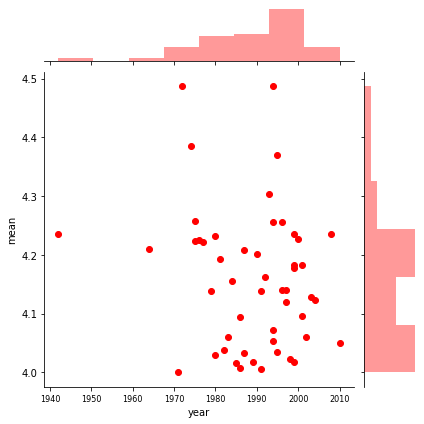

In [469]:
# Сделаем пики наглядными
sns.jointplot(x='year', y='count', data=pop_movies, kind='scatter', color='blue')
plt.show()
sns.jointplot(x='year', y='mean', data=pop_movies, kind='scatter', color='red')

Самые рейтинговые фильмы за все время преимущественно были выпущены в 1970-90-х годах с пиком в середине 90-х. Самые топовые: The Godfather (1972, 1974), The Shawshank Redemption (1994), Usual Suspects (1995), Schindler's List (1993), One Flew Over the Cuckoo's Nest (1975). Несколько фильмов выпадают из этого диапазона: Casablanca (1942), The Lord of the Rings: The Two Towers, (2002), Inception (2010) и др. В среднем они соответствуют оценке 4-4.2 балла.  

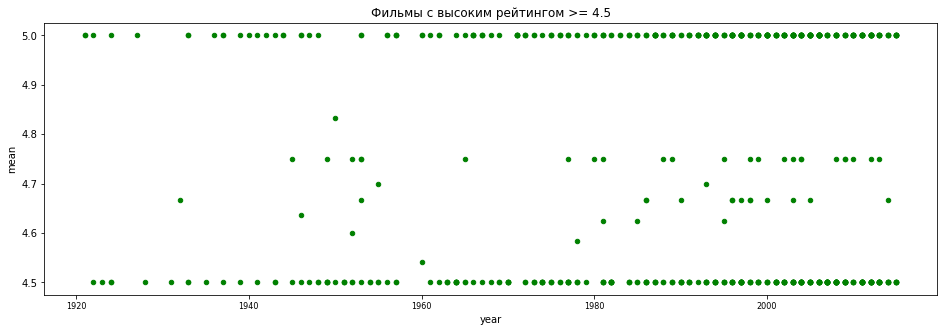

In [501]:
# Посмотрим отдельно на все фильмы с высоким рейтингом
movies_5 = all_movies.loc[all_movies['mean'] >= 4.5]
movies_5.plot(kind='scatter', 
        x='year', 
        y='mean', 
        title='Фильмы с высоким рейтингом >= 4.5',
        color='green')

Это отдельный срез того, что уже было видно раньше: фильмы с высоким рейтингом были практически всегда. И их становится больше в более поздний период (с середины 1970-х годов). По всей видимости, это связано лишь с тем, что пользователи были активнее в отношении более поздних фильмов. Однако едва ли этим частным случаям следует придавать большое значение, потому что чаще всего это мнение нескольких пользователей (максимум 12).

## Вывод


Мнение о том, что “раньше снимали настоящее кино, не то что сейчас” не подтвердилось полностью. Реальная ситуация сложнее. 

Анализ представленного набора данных показал, что самыми рейтинговыми являются фильмы 1970-1990-х годов и отчасти начала 2000-х годов. Они получили больше всего оценок (более 100) и имеют самые высокие средние (4 и выше). Кинокартины с высоким рейтингом (4.5 и выше) были на всём временном отрезке с 1920-х по 2016 годы, но количество их оценок редко превышало 10.

Вероятно, мнение о хорошем раннем кино и плохом позднем связано, во-первых, с тем, что зритель больше смотрит современное кино (оно к нему ближе во всех смыслах) и лишь выборочно знаком с работами раннего кинематографа (плохое кино быстро тонет под грузом нового), а, во-вторых, с тем, что киноиндустрия набрала обороты и стала выпускать больше фильмов — разного качества (об этом свидетельствует увеличившийся разброс среднего рейтинга начиная с 1970-х годов). 

Из-за того что фильмов с низким качеством довольно много в поздний период, поверхностный анализ (графики средней оценки за каждый год и период) показал падение среднего рейтинга от начала века к его концу. Наряду с тем, другие визуализации выявили пиковые значения с конца 1970 до начала 2000-х годов, которые потерялись за картиной средних величин.          
   
В ходе анализа возникло подозрение, что обнаруженные пики могут быть связаны с циклом жизни самого ресурса. Сайт начал работу в 1997 году. Наверняка, это было временем активного роста, когда новые пользователи залпом выставляли оценки. Естественно, для самых близких по времени фильмов, которые тогда шли в кино или по ТВ и которые они хорошо помнили из своего прошлого.  

Кроме того, не были учтены характеристики самих пользователей, потому что изначально их не было. Можно лишь предположить, что к сервису, подобному MovieLens, обращаются пользователи (преимущественно американцы) среднего культурного уровня. Это влияет на выборку фильмов, которые попадают в анализ. В целом отсутствие данных о пользователях не позволяет утверждать, что выборка была репрезентативной.  

В итоге можно заключить, что однозначно ответить на поставленный вопрос не удалось. Наш анализ, скорее, отражает мнение пользователей сайта и не является универсальным.   